#Проект: анализ факторов, влияющих на успешность компьютерных игр

*1. Загрузка данных и библиотек. Первичная оценка данных*

In [2]:
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import factorial
from math import sqrt
from scipy.stats import binom

In [4]:
games = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [5]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
games.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [7]:
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


в датасете 16715 строк, единичные пропуски в столбцах name и genre, 2% в столбце year_of_release. Данные в форматах object и float64

*2. Предобработка данных*

In [8]:
games.columns = games.columns.str.lower()

In [9]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Названия столбцов приведены к нижнему регистру. При оценке уникальных значений столбца user_score  вариант 'tbd'  расшифровывается как to be determined (будет определено), то есть в настоящее время оценка отсутсвует. Можно заменить tbd на NaN. Остальные значения столбца переведем в числовой формат

In [10]:
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

Изучим теперь столбец rating. Согласно системе ESRB (США, Мексика и Канада) игры ранжируются по возрастным категориям пользователей. Е-подходит для всех, ЕС-для самых маленьких, Е 10+ с 10 лет, Т с 13 лет, М с 17 лет, АО для взрослых. RP означает что рейтинг еще не определен, можно перевести эти строки в категорию NaN. К-А-for Kids to Adults, то есть для всех (Е)

In [11]:
games['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

In [12]:
games['rating'] = games['rating'].replace('RP', np.nan)

In [13]:
games['rating'] = games['rating'].replace('K-A', 'E')

In [14]:
games['rating'].value_counts()

E       3993
T       2961
M       1563
E10+    1420
EC         8
AO         1
Name: rating, dtype: int64

удалим пропуски в тех столбцах, где их мало. переведем столбец год выпуска в формат int

In [15]:
games=games.dropna(subset = ['name'])

In [16]:
games=games.dropna(subset = ['year_of_release'])

In [17]:
games=games.dropna(subset = ['genre'])

In [18]:
games['year_of_release'] = games['year_of_release'].astype('int')

In [19]:
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6677
dtype: int64

In [20]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9767 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


пропуски в остальных столбцах заполнить невозможно, но их слишком много чтобы удалять, поэтому оставим все как есть. Проверим датасет на дубликаты

In [21]:
games.duplicated().sum()

0

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец

In [23]:
games['sales_sum'] = games[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [24]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


**Вывод по разделу:**
загружены библиотеки и датасет, проведена оценка общей информации о датасете, обработка данных на пропуски и дубликаты, где необходимо заменены типы столбцов, добавлен столбец с общей выручкой. Переходим к исследовательскому анализу данных.

*3. Исследовательский анализ данных*

Посмотрим распределение выходов игр по годам

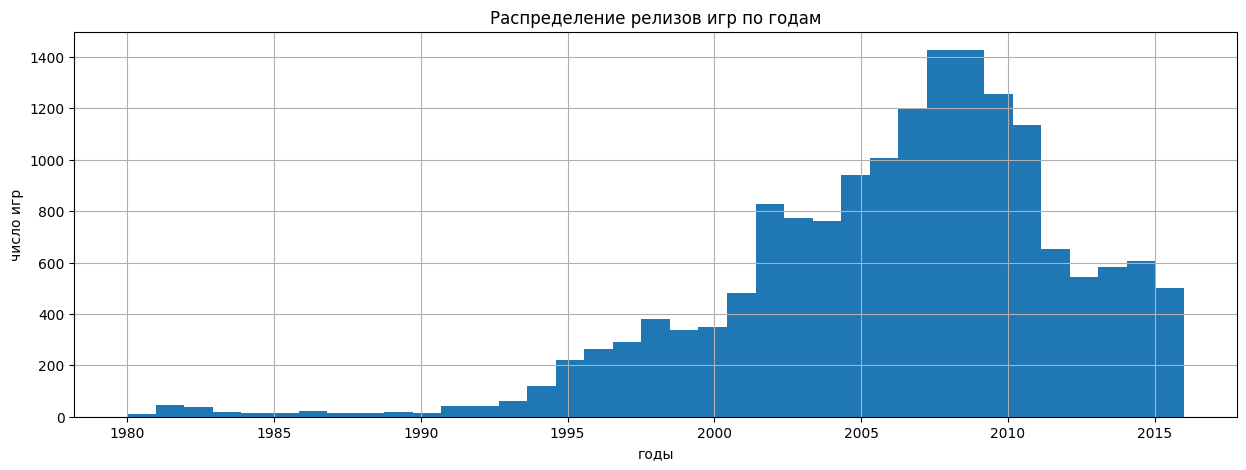

In [25]:
games['year_of_release'].hist(bins=37, grid=True, figsize=(15,5));
plt.title('Распределение релизов игр по годам');
plt.xlabel('годы');
plt.ylabel('число игр');

Наибольшее количество игр выходило в 2007-2008 годах (почти 1500 в год), после 2011г выходит стабильно около 600 игр в год. Вероятно, на смену им приходят новые технологии компьютерных игр

In [26]:
games['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: year_of_release, dtype: int64

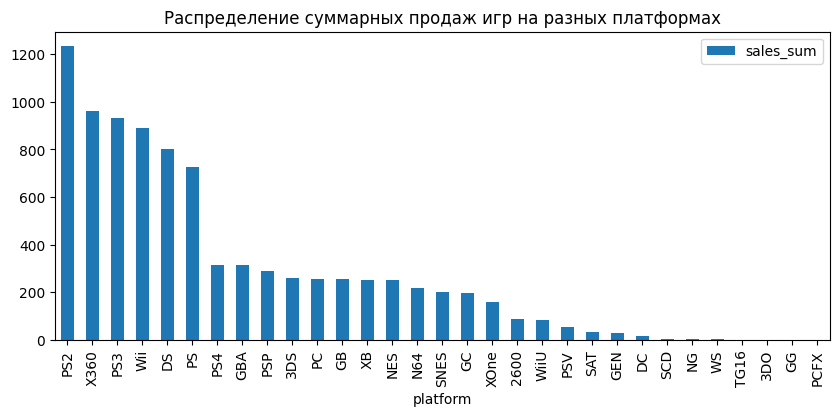

In [27]:
games.pivot_table(index='platform', values='sales_sum', aggfunc='sum').sort_values(by='sales_sum', ascending=False)\
.plot(kind='bar',title='Распределение суммарных продаж игр на разных платформах', figsize=(10,4));

Итак, уверенными лидерами продаж являются первые 6 платформ - PS2, X360, PS3, Wii, DS и PS. Построим для них распределение по годам

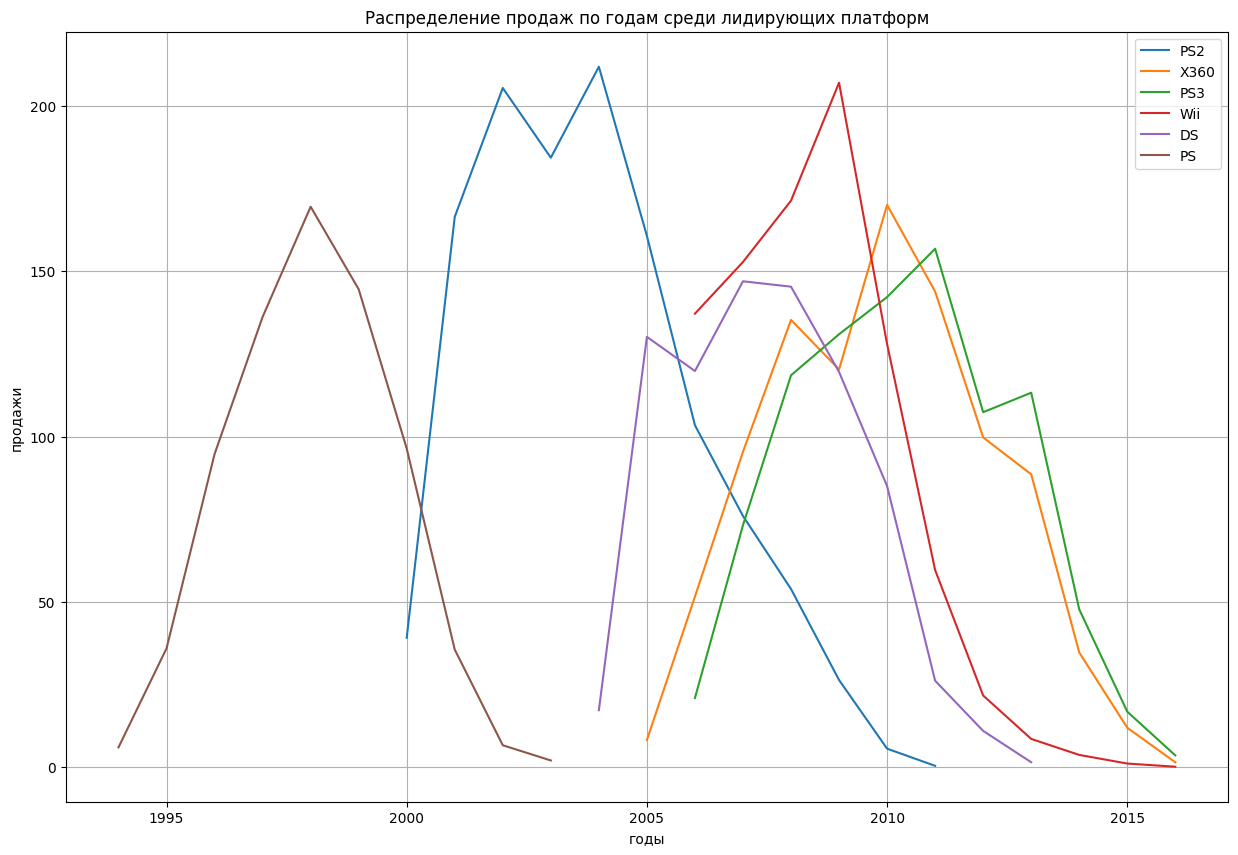

In [28]:
plt.figure(figsize=(15,10))
plt.grid(visible=bool)
plt.plot(games.query('platform=="PS2"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games.query('platform=="X360"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games.query('platform=="PS3"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games.query('platform=="Wii"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games.query('platform=="DS" and year_of_release>1985').pivot_table(index='year_of_release',
                                                                            values='sales_sum', aggfunc='sum'))
plt.plot(games.query('platform=="PS"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.xlabel('годы')
plt.ylabel('продажи')
plt.title('Распределение продаж по годам среди лидирующих платформ')
plt.legend(('PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'));

судя по графику, у всех наших лидеров количество продаваемых копий игр сошло на минимум к 2016г. То есть для планирования рекламной кампании ставку нужно делать на другие, более новые платформы. По графику видно также, что в среднем срок "жизни" платформы составляет около 10 лет, а продажи начинают резко снижаться после 5 лет работы. То есть нам нужны платформы, запущенные не раньше 2014г.

In [30]:
games_new=games.query('year_of_release>=2014')
games_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   int64  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     718 non-null    float64
 9   user_score       888 non-null    float64
 10  rating           940 non-null    object 
 11  sales_sum        1689 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 171.5+ KB


Посмотрим, какие платформы среди стартовавших после 2013г лидируют по продажам, растут, какие падают, выберем несколько потенциально прибыльных платформ

In [29]:
games_new1=games.query('year_of_release>=2014').pivot_table(index='platform', values= 'sales_sum', aggfunc=['count', 'sum', 'median'])
games_new1.columns=['count', 'sum', 'median']
games_new1.sort_values(by='sum', ascending=False)

,count,sum,median
platform,,,
PS4,376,288.15,0.185
XOne,228,140.36,0.205
3DS,212,86.68,0.090
PS3,219,68.18,0.110
X360,111,48.22,0.180
WiiU,73,42.98,0.190
PC,151,27.05,0.060
PSV,295,22.40,0.040
Wii,11,5.07,0.180


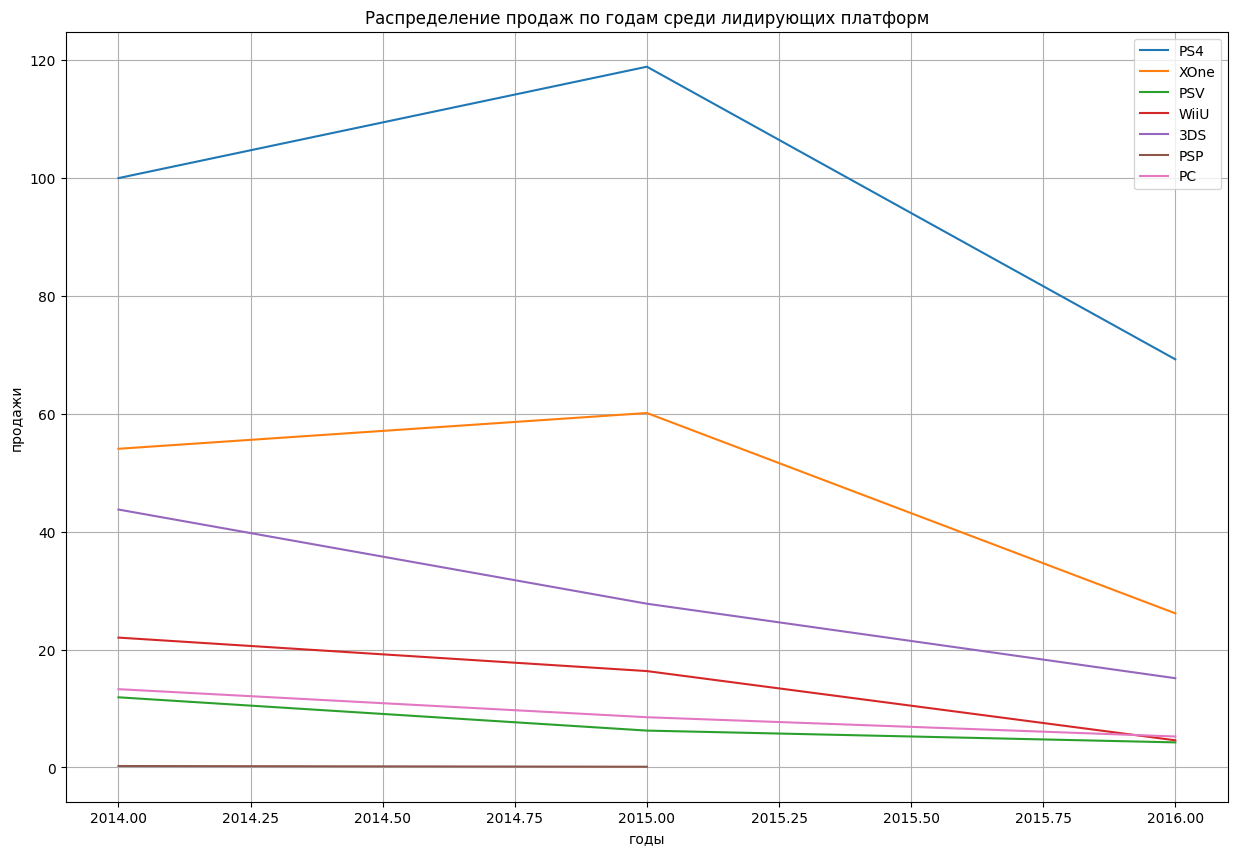

In [31]:
plt.figure(figsize=(15,10))
plt.grid(visible=bool)
plt.plot(games_new.query('platform=="PS4"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games_new.query('platform=="XOne"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games_new.query('platform=="PSV"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games_new.query('platform=="WiiU"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games_new.query('platform=="3DS"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games_new.query('platform=="PSP"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.plot(games_new.query('platform=="PC"').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum'))
plt.xlabel('годы')
plt.ylabel('продажи')
plt.title('Распределение продаж по годам среди лидирующих платформ')
plt.legend(('PS4', 'XOne', 'PSV', 'WiiU', '3DS', 'PSP', 'PC'));

наметились две лидирующие платформы для будущей рекламной кампании (PS4 и XOne). Для уточнения информации построим график по глобальным продажам игр в разбивке по платформам, вошедшим в новый датасет

In [32]:
games_new['sales_sum'].describe()

count    1689.000000
mean        0.431883
std         1.056109
min         0.010000
25%         0.030000
50%         0.100000
75%         0.350000
max        14.630000
Name: sales_sum, dtype: float64

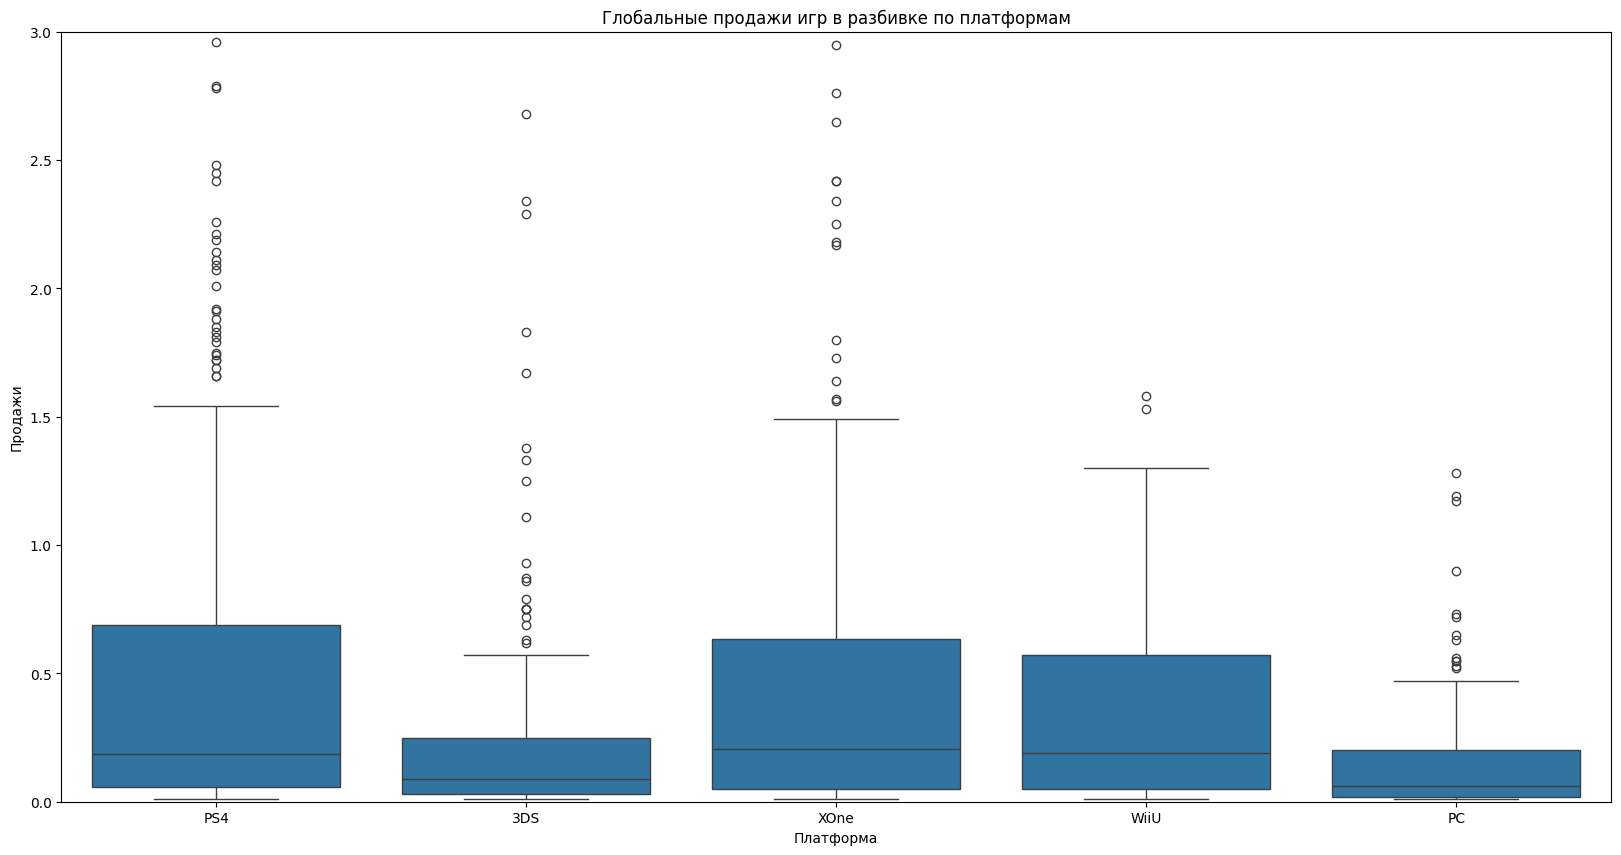

In [33]:
t=games_new.query('platform in ["PS4","XOne","WiiU","3DS","PC"]')
plt.figure(figsize=(20,10));plt.ylim(0, 3);
sns.boxplot(data=t, x='platform', y='sales_sum');plt.title('Глобальные продажи игр в разбивке по платформам');
plt.xlabel('Платформа');plt.ylabel('Продажи');

Разброс данных очень большой по всем платформам, но среди интересующих нас новых платформ лидеры продаж те же -XOne и PS4. График показывает также, что медиана продаж самая большая у XOne, чуть меньше у PS4 и у WiiU.
Посмотрим на примере первых двух корреляцию между продажами и отзывами

In [34]:
t=games_new.query('platform=="PS4"')

In [35]:
t['sales_sum'].corr(t['critic_score']).round(2)

0.4

с отзывами критиков связь прямая, средней силы

In [36]:
t['sales_sum'].corr(t['user_score']).round(2)

-0.04

с отзывами пользователей связь минимальная, еще и обратная

посмотрим связи на примере платформы с наибольшим количеством игр в нашем датасете

In [37]:
t=games_new.query('platform=="XOne"')
t['sales_sum'].corr(t['critic_score']).round(2)

0.43

In [38]:
t['sales_sum'].corr(t['user_score']).round(2)

-0.07

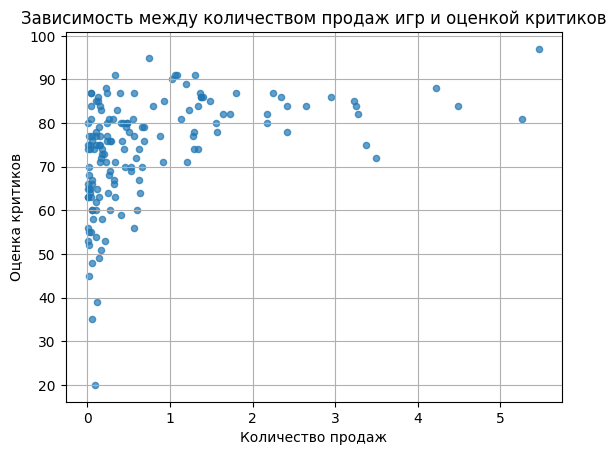

In [39]:
t.plot(x='sales_sum', y='critic_score', kind ='scatter', title='Зависимость между количеством продаж игр и оценкой критиков',\
       alpha=0.7, grid=True, sharex=False);plt.xlabel('Количество продаж');
plt.ylabel('Оценка критиков');

тенденция сохраняется, делаем вывод что отзывы пользователей не влияют на продажи, отзывы критиков влияют умеренно и только на начальном этапе продаж (для первых трех миллионов копий, далее связь минимальная)

In [ ]:
games_new['sales_sum'].corr(games_new['critic_score']).round(2)

In [41]:
games_new['sales_sum'].corr(games_new['user_score']).round(2)

-0.01

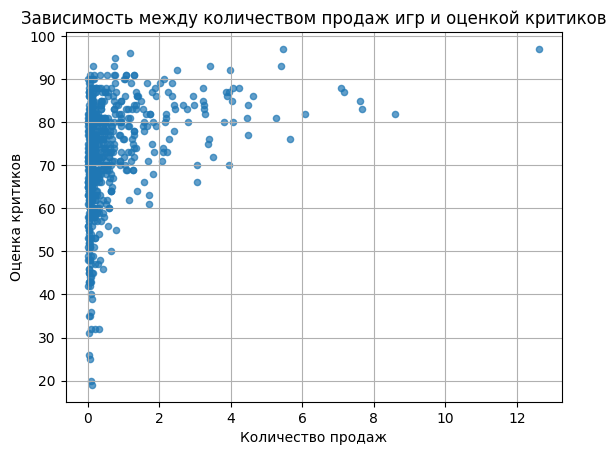

In [42]:
games_new.plot(x='sales_sum', y='critic_score', kind ='scatter', title='Зависимость между количеством продаж игр и оценкой критиков',\
       alpha=0.7, grid=True, sharex=False);plt.xlabel('Количество продаж');
plt.ylabel('Оценка критиков');

для датасета с новыми платформами в целом зависимости те же.

Посмотрим на общее распределение игр по жанрам, выделим самые прибыльные. Проверим, выделяются ли жанры с высокими и низкими продажами.

In [43]:
games_to_genres = games_new.pivot_table(index='genre', values='sales_sum',\
                      aggfunc=['count', 'sum', 'mean']).sort_values(by=('mean','sales_sum'), ascending=False)
games_to_genres.columns = ['количество игр', 'количество проданных копий', 'среднее количество проданных копий на 1 игру']
games_to_genres

,количество игр,количество проданных копий,среднее количество проданных копий на 1 игру
genre,,,
Shooter,128,170.94,1.335469
Sports,161,109.48,0.680000
Platform,38,18.09,0.476053
Fighting,60,28.22,0.470333
Role-Playing,221,101.44,0.459005
Racing,69,27.52,0.398841
Misc,113,37.55,0.332301
Action,619,199.36,0.322068
Simulation,44,13.13,0.298409


Самым популярным жанром по количеству проданных копий каждой игры является Shooter, в тройку лидеров входят также Sports и Platform, самыми непопулярными являются Adventure, Strategy, Puzzle.

**Выводы по исследовательскому анализу:**

1.Наибольшее количество игр выходило в 2007-2008 годах (почти 1500 в год), после 2011г выходит стабильно около 600 игр в год. Вероятно, на смену им приходят новые технологии компьютерных игр.

2.Лидерами продаж за весь период наблюдения являются 6 платформ - PS2, X360, PS3, Wii, DS и PS. Анализ распределения показал, что у всех лидеров количество продаж стало близким к нулю к 2016г. То есть для планирования рекламной кампании ставку нужно делать на другие, более новые платформы. Также определено, что в среднем срок "жизни" платформы составляет около 12 лет, а продажи начинают резко снижаться после 5-6 лет работы. То есть нам нужны платформы, запущенные не раньше 2011г.

3.В результате анализа данных были выделены две лидирующие платформы для будущей рекламной кампании (PS4 и XOne). Изучение продаж игр в разбивке по платформам показало, что разброс данных очень большой по всем платформам, но среди интересующих нас новых платформ лидеры продаж те же -XOne и PS4.

4.Изучение корреляции между продажами и отзывами по играм показало, что отзывы пользователей не влияют на продажи, отзывы критиков влияют умеренно и только на начальном этапе продаж (для первых трех миллионов копий, далее связь минимальная). Данные аналогичны как для лидеров, так и для датасета в целом.

5.Самым популярным жанром по количеству проданных копий каждой игры является Shooter, в тройку лидеров входят также Platform и Sports, самыми непопулярными являются Adventure, Puzzle и Strategy.

*4. Портрет пользователя каждого региона*

Определим для пользователя каждого региона (NA, EU, JP):

1.Самые популярные платформы (топ-5). Опишем различия в долях продаж.

2.Самые популярные жанры (топ-5).

3.Влияет ли рейтинг ESRB на продажи в отдельном регионе?

*Сначала посмотрим популярность платформ по регионам*

In [44]:
games_new.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales','other_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales,other_sales
platform,,,,
3DS,16.12,44.24,22.64,3.68
PC,17.97,0.00,7.23,1.85
PS3,25.54,11.22,22.05,9.37
PS4,130.04,15.02,98.61,44.48
PSP,0.00,0.36,0.00,0.00
PSV,3.53,14.54,2.52,1.81
Wii,2.59,0.00,2.08,0.40
WiiU,13.15,7.31,19.36,3.16
X360,15.49,0.08,28.30,4.35


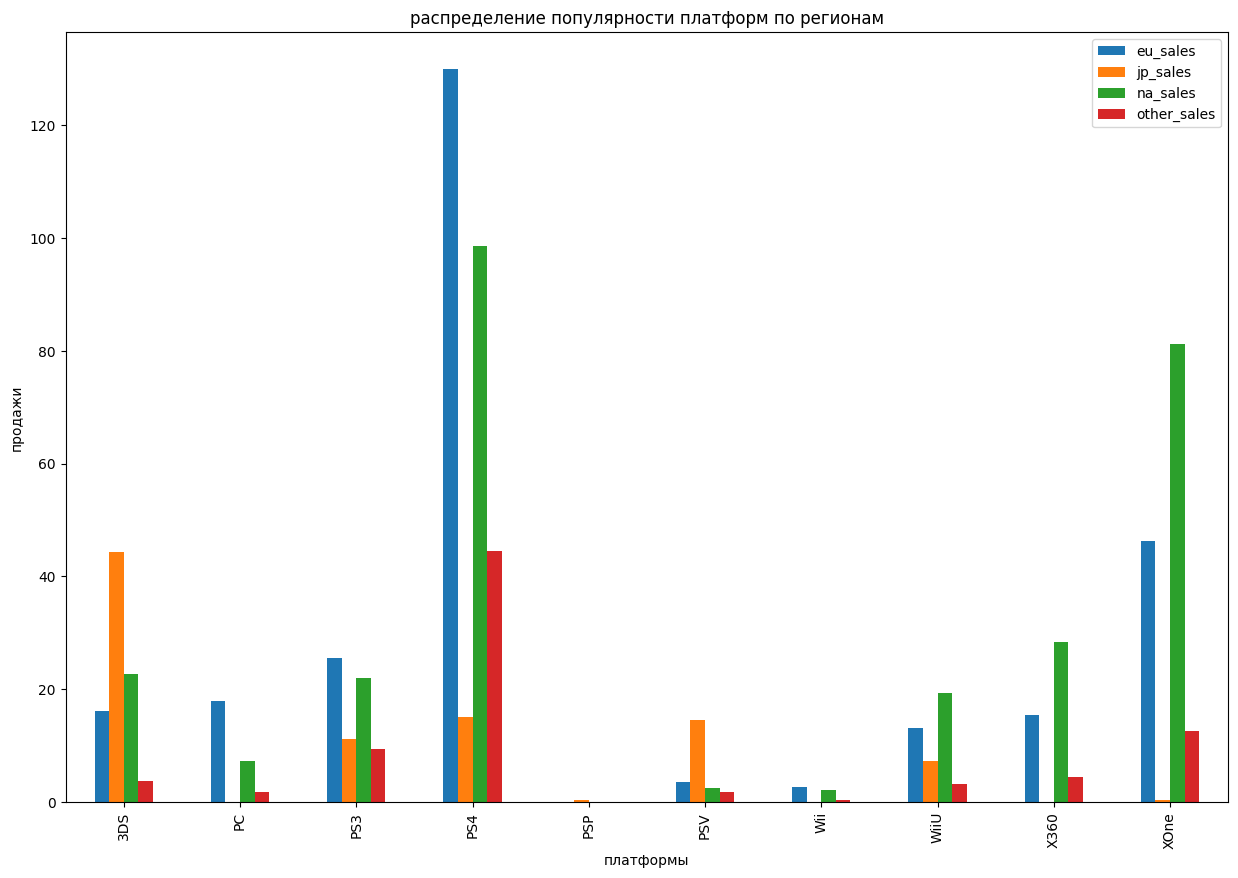

In [45]:
games_new.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales','other_sales'], \
                      aggfunc='sum').plot.bar(title='распределение популярности платформ по регионам',\
                                            xlabel='платформы', ylabel='продажи', figsize=(15,10));

график по всем регионам показывает различия предпочтений пользователей по отдельным платформам в разных регионах. Посмотрим теперь на каждый регион отдельно.

In [46]:
games_sales_na=games_new.groupby('platform')['na_sales'].sum().sort_values(ascending=False)
games_sales_na=pd.concat([games_sales_na[:5], pd.Series(games_sales_na[5:].sum(), index=['other platforms'])])
games_sales_na

PS4                98.61
XOne               81.27
X360               28.30
3DS                22.64
PS3                22.05
other platforms    31.19
dtype: float64

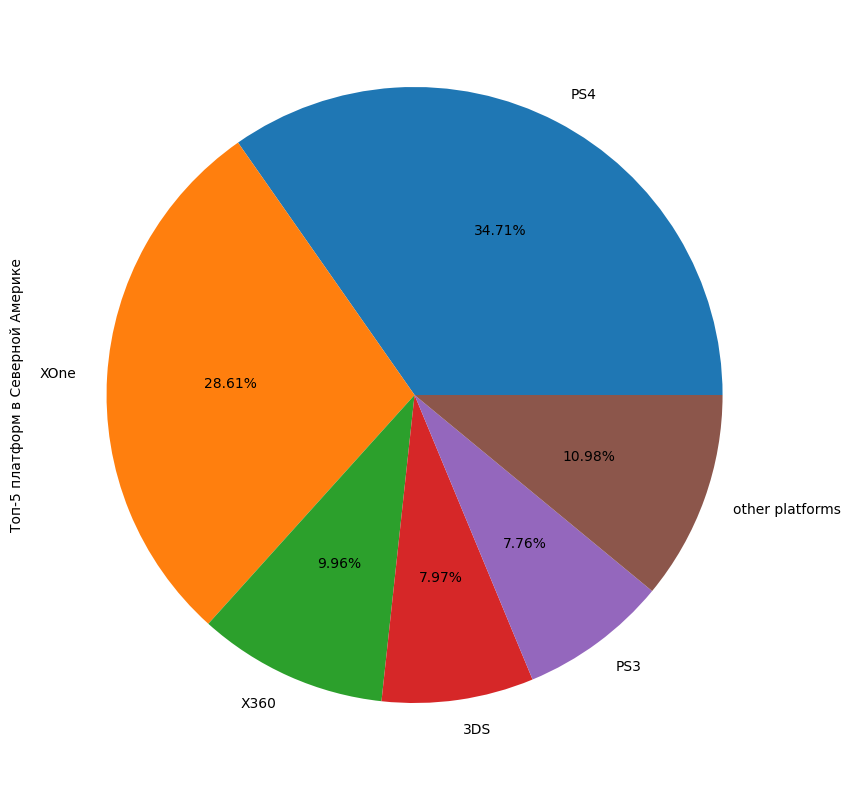

In [47]:
games_sales_na.plot(kind='pie', ylabel='Топ-5 платформ в Северной Америке', autopct='%1.2f%%',  figsize=(15,10));

В Северной Америке основным лидером среди платформ является PS4 (34,7% продаж), на втором месте XOne (28,6%), в топ-5 также входят Х360 (9,9%), 3DS (7,9%) и PS3 (7,7%)

In [48]:
games_sales_eu=games_new.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)
games_sales_eu=pd.concat([games_sales_eu[:5], pd.Series(games_sales_eu[5:].sum(), index=['other platforms'])])
games_sales_eu

PS4                130.04
XOne                46.25
PS3                 25.54
PC                  17.97
3DS                 16.12
other platforms     34.76
dtype: float64

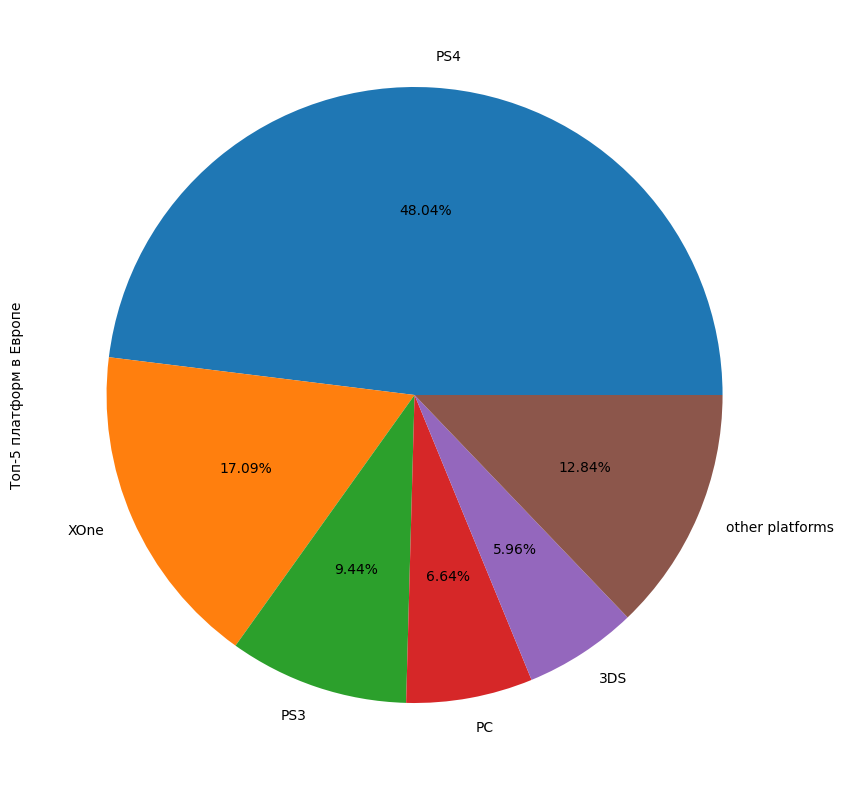

In [49]:
games_sales_eu.plot(kind='pie', ylabel='Топ-5 платформ в Европе', autopct='%1.2f%%',  figsize=(15,10));

В Европе основным лидером среди платформ также является PS4 с еще большим преимуществом (48% продаж), на втором месте XOne (17%), в топ-5 также входят PS3 (9,4%), PC (6,6%) и 3DS (5,9%)

In [50]:
games_sales_jp=games_new.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)
games_sales_jp=pd.concat([games_sales_jp[:5], pd.Series(games_sales_jp[5:].sum(), index=['other platforms'])])
games_sales_jp

3DS                44.24
PS4                15.02
PSV                14.54
PS3                11.22
WiiU                7.31
other platforms     0.76
dtype: float64

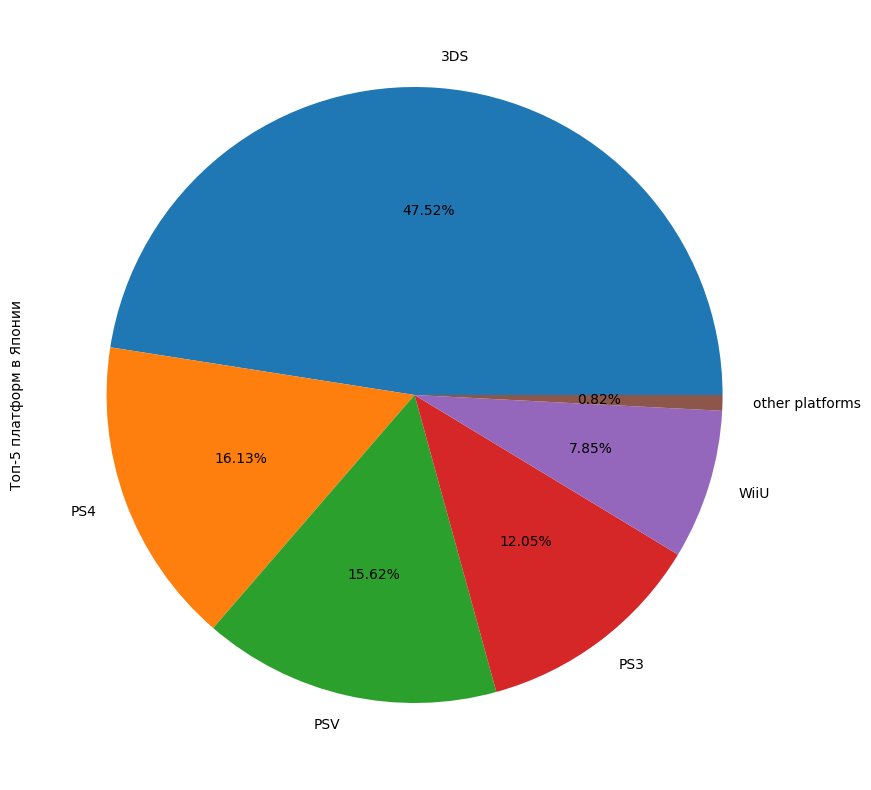

In [51]:
games_sales_jp.plot(kind='pie', ylabel='Топ-5 платформ в Японии', autopct='%1.2f%%',  figsize=(15,10));

В Японии основным лидером среди платформ с большим отрывом является 3DS (47,5% продаж), на втором месте PS4 (16%), в топ-5 также входят PSV (15.6%), PS3 (12%) и WiiU (7.8%)

In [52]:
games_sales_other=games_new.groupby('platform')['other_sales'].sum().sort_values(ascending=False)
games_sales_other=pd.concat([games_sales_other[:5], pd.Series(games_sales_other[5:].sum(), index=['other platforms'])])
games_sales_other

PS4                44.48
XOne               12.52
PS3                 9.37
X360                4.35
3DS                 3.68
other platforms     7.22
dtype: float64

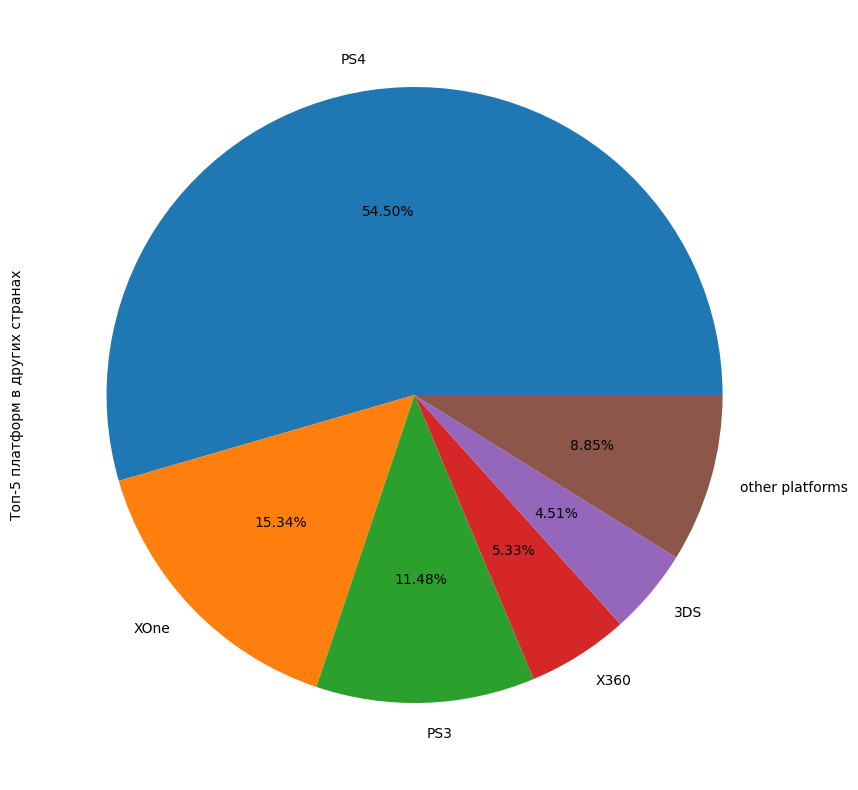

In [53]:
games_sales_other.plot(kind='pie', ylabel='Топ-5 платформ в других странах', autopct='%1.2f%%',  figsize=(15,10));

В других странах основным лидером среди платформ является PS4 - обеспечивает более половины всех продаж (54,5%), на втором месте XOne (15,3%), в топ-5 также входят PS3 (11,5%), Х360 (5,3%) и 3DS (4,5%)

*Определим самые популярные жанры в каждом регионе (топ-5).*

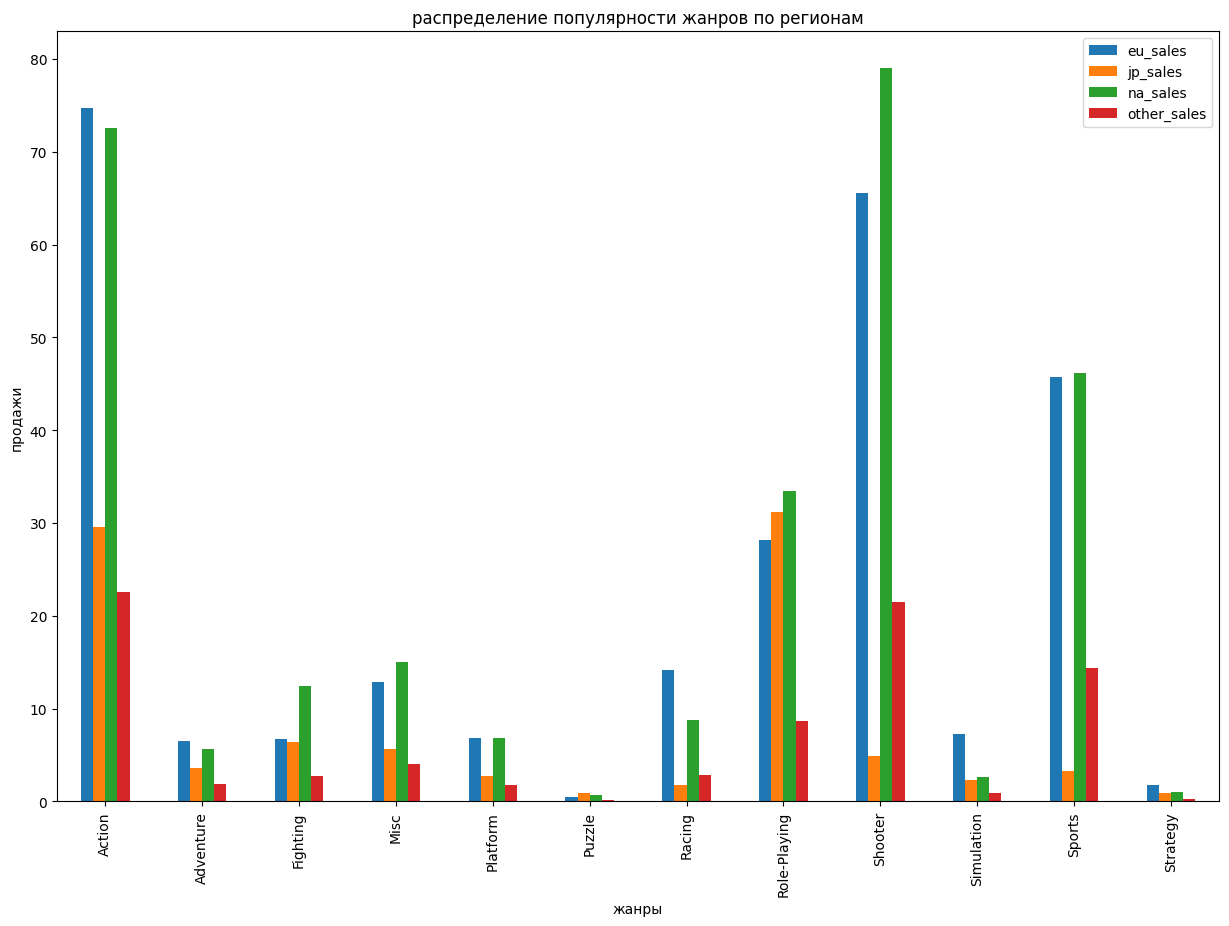

In [54]:
games_new.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales','other_sales'], \
                      aggfunc='sum').plot.bar(title='распределение популярности жанров по регионам',\
                                            xlabel='жанры', ylabel='продажи', figsize=(15,10));

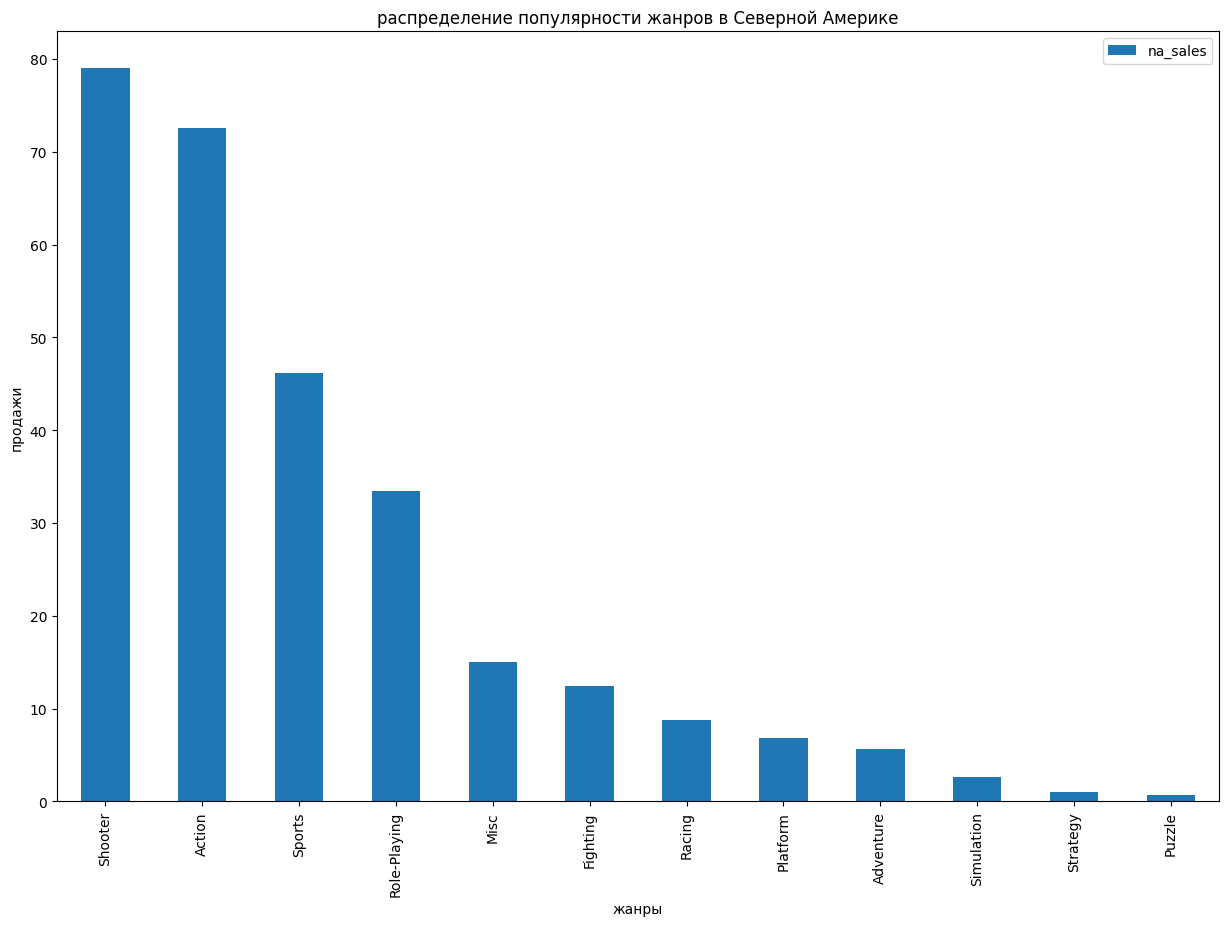

In [55]:
games_new.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False). plot.bar\
(title='распределение популярности жанров в Cеверной Америке', xlabel='жанры', ylabel='продажи', figsize=(15,10));

В Северной Америке в топ-5 жанров предпочитаемых игр входят Shooter, Action, Sports, Role-Playing и Misc.

games_new.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', asc

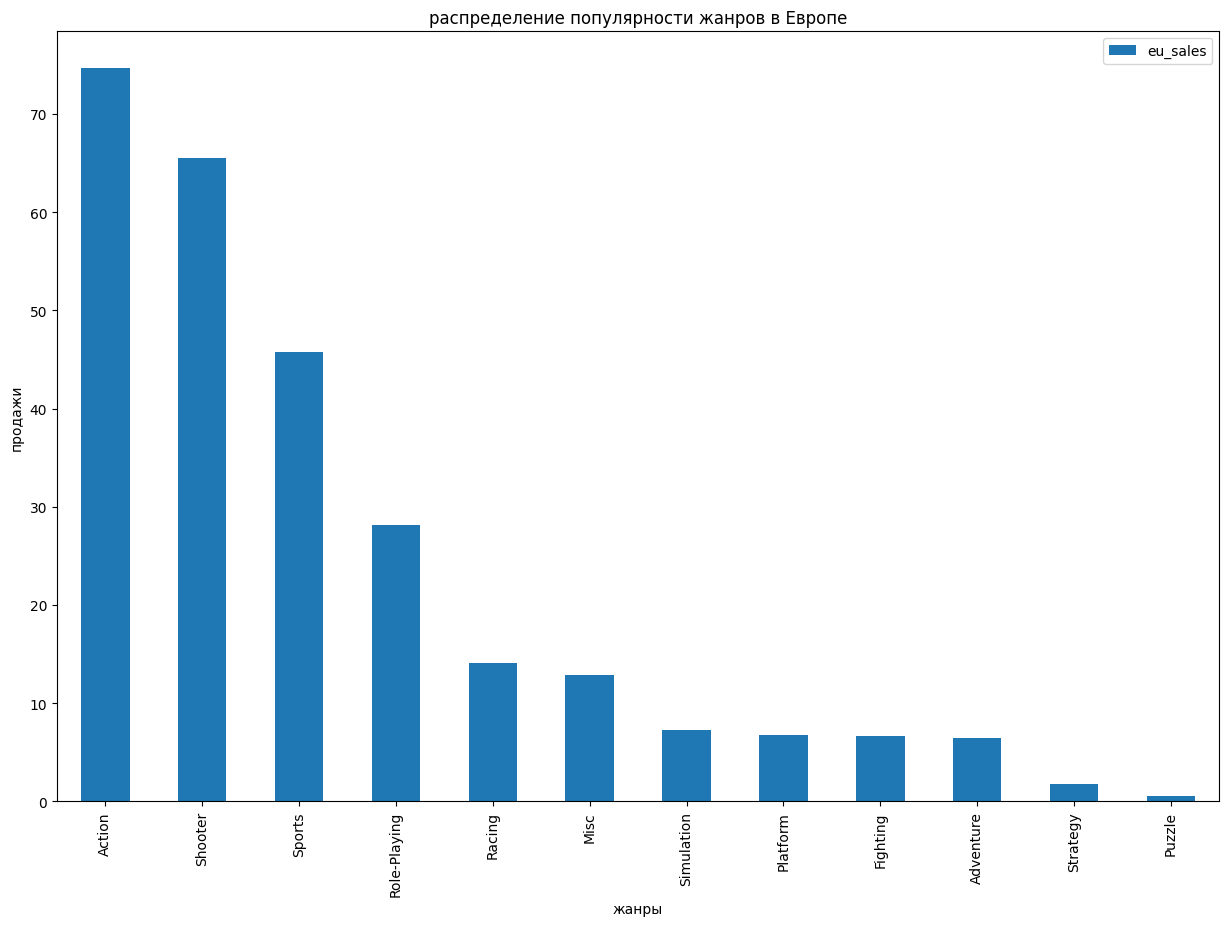

In [56]:
games_new.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False). plot.bar\
(title='распределение популярности жанров в Европе', xlabel='жанры', ylabel='продажи', figsize=(15,10));

В Европе в топ-5 жанров входят Action, Shooter, Sports, Role-Playing и Racing

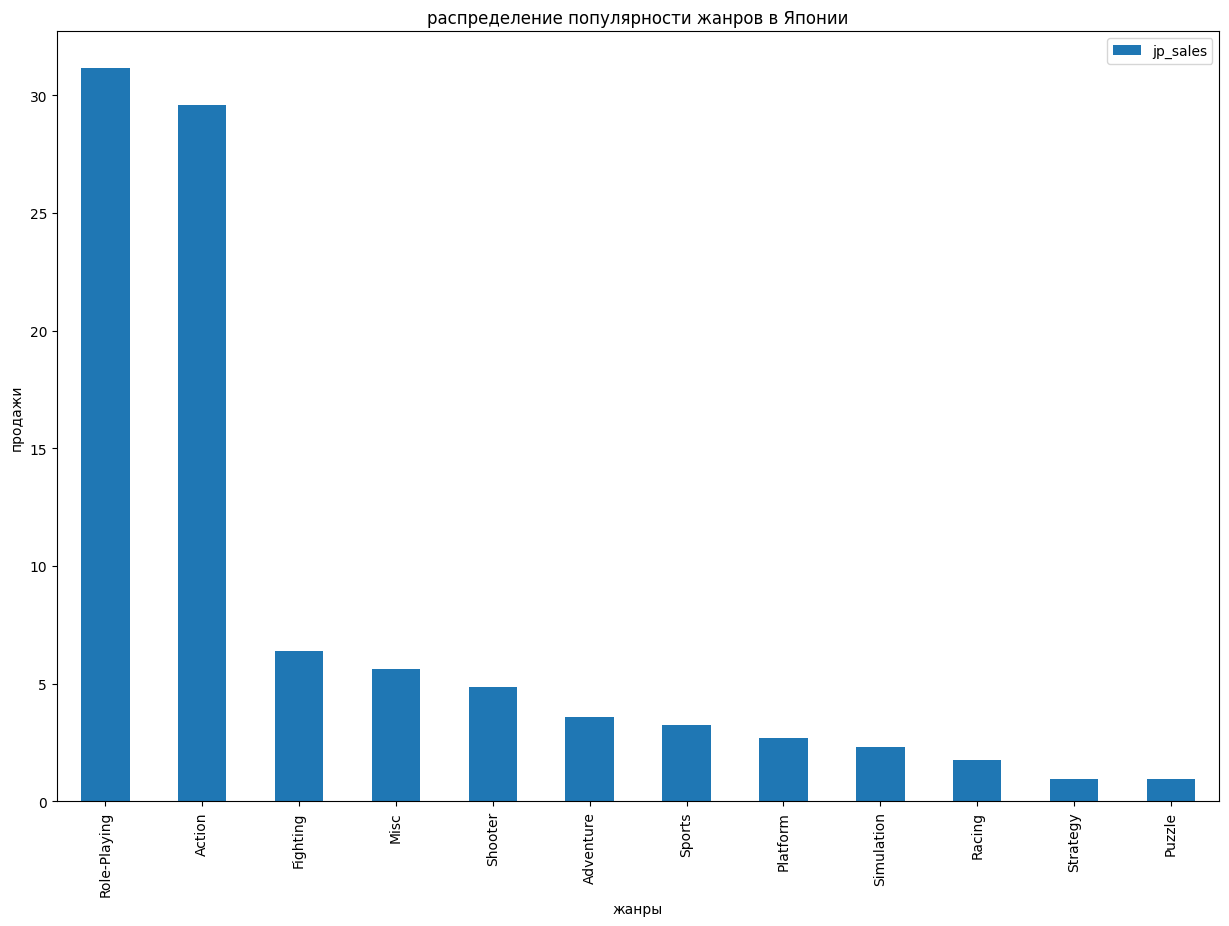

In [57]:
games_new.pivot_table(index='genre', values='jp_sales',aggfunc='sum').sort_values(by='jp_sales', ascending=False). plot.bar\
(title='распределение популярности жанров в Японии', xlabel='жанры', ylabel='продажи', figsize=(15,10));

В Японии в топ-5 жанров входят Role-Playing, Action, Fighiting, Misc и Shooter

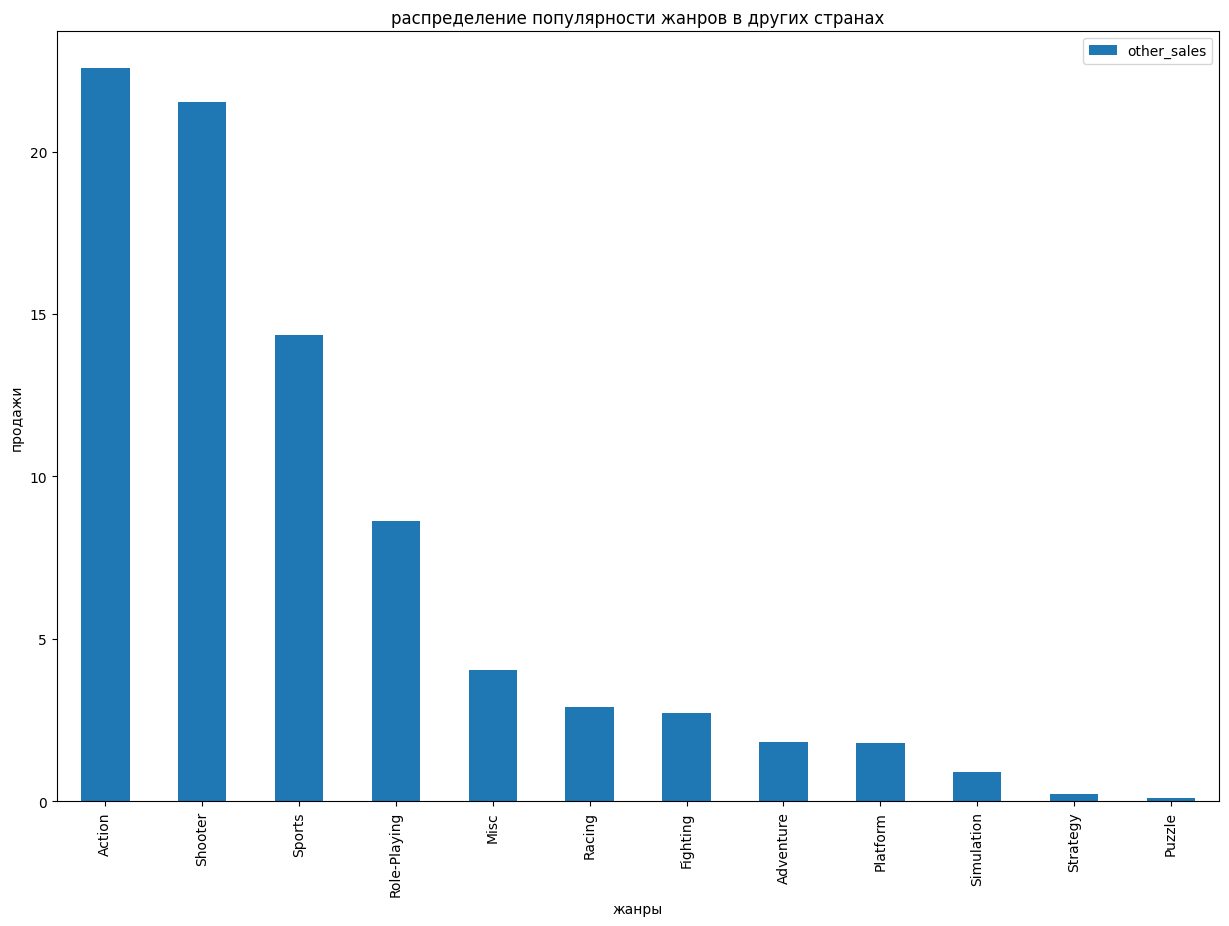

In [58]:
games_new.pivot_table(index='genre', values='other_sales', aggfunc='sum').sort_values(by='other_sales', ascending=False). \
plot.bar(title='распределение популярности жанров в других странах', xlabel='жанры', ylabel='продажи', figsize=(15,10));

В других странах в топ-5 входят Action, Shooter, Sports, Role-Playing и Misc. Различия в популярности жанров могут быть связаны с распространенностью в регионе платформ, для которых игры такого жанра создаются. Проверим эту теорию

In [59]:
games_new.query('platform=="PS4"').pivot_table(index='genre', values='name',
                                               aggfunc='count').sort_values(by='name', ascending=False)

,name
genre,
Action,142
Role-Playing,51
Sports,42
Shooter,38
Adventure,28
Misc,19
Racing,18
Fighting,17
Platform,9


In [60]:
games_new.query('platform=="3DS"').pivot_table(index='genre', values='name',
                                               aggfunc='count').sort_values(by='name', ascending=False)

,name
genre,
Action,87
Role-Playing,41
Adventure,21
Misc,20
Simulation,10
Platform,8
Strategy,8
Puzzle,7
Fighting,5


Похоже, теория верна: чем больше игр определенного жанра выпускает самая популярная в регионе платформа, тем больше продажи этого жанра в регионе

*Посмотрим, влияет ли рейтинг ESRB на продажи в отдельном регионе*

In [61]:
games_new.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales','other_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,58.06,8.94,50.74,15.39
E10+,26.16,4.46,33.23,7.83
M,93.44,8.01,96.42,28.67
T,34.07,14.78,38.95,11.33


В Европе, Северной Америке и других странах наибольшие продажи у игр с рейтингом М, в Японии - с рейтингом Т. Как мы помним, согласно системе ESRB игры ранжируются по возрастным категориям пользователей. Е-подходит для всех, ЕС-для самых маленьких, Е 10+ с 10 лет, Т с 13 лет, М с 17 лет, АО для взрослых. Посмотрим на распределение игр по рейтингам на 2 платформах - PS4, как самой популярной в большинстве регионов и 3DS как самой популярной в Японии.

In [62]:
games_new.query('platform=="PS4"').pivot_table(index='rating', values='name', aggfunc='count')

,name
rating,
E,49
E10+,34
M,72
T,85


In [63]:
games_new.query('platform=="3DS"').pivot_table(index='rating', values='name', aggfunc='count')

,name
rating,
E,26
E10+,30
M,3
T,15


Как мы видим, PS4 выпускает достаточно много игр как для взрослых, так и для подростков, но в принципе является универсальной и игр для всех и для самых маленьких тоже много. 3DS же игры 17+ практически не выпускает, при этом игр для детей 10+ большинство, на втором месте игры для всех, на 3-м для подростков. Так как подростки могут играть во все эти типы игр, ставка в Японии явно сделана на них, как на основную аудиторию.

**Вывод по разделу:**

1.В Северной Америке основным лидером среди платформ является PS4 (34,7% продаж), на втором месте XOne (28,6%), в топ-5 также входят Х360 (9,9%), 3DS (7,9%) и PS3 (7,7%), в Европе основным лидером среди платформ также является PS4 с еще большим преимуществом (48% продаж), на втором месте XOne (17%), в топ-5 также входят PS3 (9,4%), PC (6,6%) и 3DS (5,9%). В Японии доминирует 3DS (47,5% продаж), на втором месте PS4 (16%), в топ-5 также входят PSV (15.6%), PS3 (12%) и WiiU (7.8%). В других странах основным лидером среди платформ является PS4 - обеспечивает более половины всех продаж (54,5%), на втором месте XOne (15,3%), в топ-5 также входят PS3 (11,5%), Х360 (5,3%) и 3DS (4,5%).

2.В Северной Америке в топ-5 жанров предпочитаемых игр входят Shooter, Action, Sports, Role-Playing и Misc, в Европе Action, Shooter, Sports, Role-Playing и Racing, в Японии Role-Playing, Action, Fighiting, Misc и Shooter, в других странах Action, Shooter, Sports, Role-Playing и Misc. Различия в популярности жанров наиболее вероятно связаны с распространенностью в регионе платформ, для которых игры такого жанра создаются.

3.В Европе, Северной Америке и других странах наибольшие продажи у игр с рейтингом М, в Японии - с рейтингом Т. Анализ показал, что PS4 выпускает достаточно много игр как для взрослых, так и для подростков, но в принципе является универсальной и игр для всех и для самых маленьких тоже много. 3DS же игры 17+ практически не выпускает, при этом игр для детей 10+ большинство, на втором месте игры для всех, на 3-м для подростков. Так как подростки могут играть во все эти типы игр, ставка в Японии явно сделана на них, как на основную аудиторию.

*5. Проверка гипотез*

**Гипотеза 1.** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

За нулевую гипотезу примем положение, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Альтернативной гипотезой будет утверждение что рейтинги неодинаковые. Применим двусторонний Т-тест для двух независимых генеральных совокупностей к средним значениям пользовательских рейтингов для двух датасетов.

In [64]:
games_filt_xone=games_new.query('platform=="XOne"')
games_filt_xone = games_filt_xone.dropna(subset=['user_score'])
games_filt_xone.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 165 to 16660
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             165 non-null    object 
 1   platform         165 non-null    object 
 2   year_of_release  165 non-null    int64  
 3   genre            165 non-null    object 
 4   na_sales         165 non-null    float64
 5   eu_sales         165 non-null    float64
 6   jp_sales         165 non-null    float64
 7   other_sales      165 non-null    float64
 8   critic_score     151 non-null    float64
 9   user_score       165 non-null    float64
 10  rating           159 non-null    object 
 11  sales_sum        165 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 16.8+ KB


In [65]:
games_filt_pc=games_new.query('platform=="PC"')
games_filt_pc = games_filt_pc.dropna(subset=['user_score'])
games_filt_pc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122 entries, 458 to 16692
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             122 non-null    object 
 1   platform         122 non-null    object 
 2   year_of_release  122 non-null    int64  
 3   genre            122 non-null    object 
 4   na_sales         122 non-null    float64
 5   eu_sales         122 non-null    float64
 6   jp_sales         122 non-null    float64
 7   other_sales      122 non-null    float64
 8   critic_score     115 non-null    float64
 9   user_score       122 non-null    float64
 10  rating           109 non-null    object 
 11  sales_sum        122 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 12.4+ KB


In [66]:
print('Средняя оценка пользователями игр на платформе XOne:', games_filt_xone['user_score'].mean().round(2))
print('Средняя оценка пользователями игр на платформе PC:', games_filt_pc['user_score'].mean().round(2))
results = st.ttest_ind(games_filt_xone['user_score'], games_filt_pc['user_score'])
alpha=0.05
print('p-значение:', results.pvalue)
if results.pvalue<alpha:
    print('Нулевая гипотеза о равенстве среднего пользовательского рейтинга платформ отвергнута, есть основания утверждать, что средние  пользовательские рейтинги платформ Xbox One и PC неодинаковые')
else:
    print('Не удалось отвергнуть нулевую гипотезу, есть основания утверждать, что средние  пользовательские рейтинги платформ Xbox One и PC одинаковые')

Средняя оценка пользователями игр на платформе XOne: 6.59
Средняя оценка пользователями игр на платформе PC: 6.3
p-значение: 0.10450507919348415
Не удалось отвергнуть нулевую гипотезу, есть основания утверждать, что средние  пользовательские рейтинги платформ Xbox One и PC одинаковые


**Гипотеза 2.** Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

За нулевую гипотезу примем положение что средний пользовательский рейтинг жанра Action равен рейтингу жанра Sports. Альтернативной гипотезой будет утверждение что рейтинги Action и Sports не равны. Снова применим двусторонний Т-тест для двух независимых генеральных совокупностей к средним значениям пользовательских рейтингов для двух датасетов.

In [67]:
games_filt_action=games_new.query('genre=="Action"')
games_filt_action = games_filt_action.dropna(subset=['user_score'])
games_filt_action.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 42 to 16692
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             297 non-null    object 
 1   platform         297 non-null    object 
 2   year_of_release  297 non-null    int64  
 3   genre            297 non-null    object 
 4   na_sales         297 non-null    float64
 5   eu_sales         297 non-null    float64
 6   jp_sales         297 non-null    float64
 7   other_sales      297 non-null    float64
 8   critic_score     227 non-null    float64
 9   user_score       297 non-null    float64
 10  rating           287 non-null    object 
 11  sales_sum        297 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 30.2+ KB


In [68]:
games_filt_sports=games_new.query('genre=="Sports"')
games_filt_sports = games_filt_sports.dropna(subset=['user_score'])
games_filt_sports.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 77 to 16643
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             127 non-null    object 
 1   platform         127 non-null    object 
 2   year_of_release  127 non-null    int64  
 3   genre            127 non-null    object 
 4   na_sales         127 non-null    float64
 5   eu_sales         127 non-null    float64
 6   jp_sales         127 non-null    float64
 7   other_sales      127 non-null    float64
 8   critic_score     83 non-null     float64
 9   user_score       127 non-null    float64
 10  rating           123 non-null    object 
 11  sales_sum        127 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 12.9+ KB


In [69]:
print('Средняя оценка пользователями игр жанра Action:', games_filt_action['user_score'].mean().round(2))
print('Средняя оценка пользователями игр жанра Sports:', games_filt_sports['user_score'].mean().round(2))
results = st.ttest_ind(games_filt_action['user_score'], games_filt_sports['user_score'])
print('p-значение:', results.pvalue)
if results.pvalue<0.05:
    print('Нулевая гипотеза о равенстве средних рейтингов игр в жанрах Action и Sports отвергнута, есть основания утверждать, что средние пользовательские рейтинги жанров Action  и Sports не равны')
else:
    print('Не удалось отвергнуть нулевую гипотезу, есть основания утверждать, что средние  пользовательские рейтинги жанров равны')


Средняя оценка пользователями игр жанра Action: 6.76
Средняя оценка пользователями игр жанра Sports: 5.23
p-значение: 2.8711147985105864e-19
Нулевая гипотеза о равенстве средних рейтингов игр в жанрах Action и Sports отвергнута, есть основания утверждать, что средние пользовательские рейтинги жанров Action  и Sports не равны


**Вывод по разделу.** Проведена проверка двух гипотез:

Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Результат проверки: Не удалось отвергнуть нулевую гипотезу, есть основания утверждать, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Гипотеза 2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. Результат проверки: Нулевая гипотеза о равенстве средних рейтингов игр в жанрах Action и Sports отвергнута, есть основания утверждать, что средние пользовательские рейтинги жанров Action и Sports не равны.

**Общий вывод**

1.загружены библиотеки и датасет, проведена оценка общей информации о датасете, обработка данных на пропуски и дубликаты, где необходимо заменены типы столбцов, добавлен столбец с общей выручкой.

2.Наибольшее количество игр выходило в 2007-2008 годах (почти 1500 в год), после 2011г выходит стабильно около 600 игр в год. Вероятно, на смену им приходят новые технологии компьютерных игр.

2.Лидерами продаж за весь период наблюдения являются 6 платформ - PS2, X360, PS3, Wii, DS и PS. Анализ распределения показал, что у всех лидеров количество продаж стало близким к нулю к 2016г. То есть для планирования рекламной кампании ставку нужно делать на другие, более новые платформы. Также определено, что в среднем срок "жизни" платформы составляет около 12 лет, а продажи начинают резко снижаться после 5-6 лет работы. То есть нам нужны платформы, запущенные не раньше 2011г.

3.В результате анализа данных были выделены две лидирующие платформы для будущей рекламной кампании (PS4 и XOne). Изучение продаж игр в разбивке по платформам показало, что разброс данных очень большой по всем платформам, но среди интересующих нас новых платформ лидеры продаж те же - XOne и PS4.

4.Изучение корреляции между продажами и отзывами по играм показало, что отзывы пользователей не влияют на продажи, отзывы критиков влияют умеренно и только на начальном этапе продаж (для первых трех миллионов копий, далее связь минимальная). Данные аналогичны как для лидеров, так и для датасета в целом.

5.Самым популярным жанром по количеству проданных копий каждой игры является Shooter, в тройку лидеров входят также Platform и Sports, самыми непопулярными являются Adventure, Puzzle и Strategy.

6.В Северной Америке основным лидером среди платформ является PS4 (34,7% продаж), на втором месте XOne (28,6%), в топ-5 также входят Х360 (9,9%), 3DS (7,9%) и PS3 (7,7%), в Европе основным лидером среди платформ также является PS4 с еще большим преимуществом (48% продаж), на втором месте XOne (17%), в топ-5 также входят PS3 (9,4%), PC (6,6%) и 3DS (5,9%). В Японии доминирует 3DS (47,5% продаж), на втором месте PS4 (16%), в топ-5 также входят PSV (15.6%), PS3 (12%) и WiiU (7.8%). В других странах основным лидером среди платформ является PS4 - обеспечивает более половины всех продаж (54,5%), на втором месте XOne (15,3%), в топ-5 также входят PS3 (11,5%), Х360 (5,3%) и 3DS (4,5%).

7.В Северной Америке в топ-5 жанров предпочитаемых игр входят Shooter, Action, Sports, Role-Playing и Misc, в Европе Action, Shooter, Sports, Role-Playing и Racing, в Японии Role-Playing, Action, Fighiting, Misc и Shooter, в других странах Action, Shooter, Sports, Role-Playing и Misc. Различия в популярности жанров наиболее вероятно связаны с распространенностью в регионе платформ, для которых игры такого жанра создаются.

8.В Европе, Северной Америке и других странах наибольшие продажи у игр с рейтингом М, в Японии - с рейтингом Т. Анализ показал, что PS4 выпускает достаточно много игр как для взрослых, так и для подростков, но в принципе является универсальной и игр для всех и для самых маленьких тоже много. 3DS же игры 17+ практически не выпускает, при этом игр для детей 10+ большинство, на втором месте игры для всех, на 3-м для подростков. Так как подростки могут играть во все эти типы игр, ставка в Японии явно сделана на них, как на основную аудиторию.

9.Проведена проверка двух гипотез о равенстве пользовательских оценок для отдельных платформ и жанров. В результате проверки не удалось отвергнуть нулевую гипотезу о равенстве рейтингов платформ Xbox One и PC, есть основания утверждать, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Нулевая гипотеза о равенстве средних рейтингов игр в жанрах Action и Sports отвергнута, есть основания утверждать, что средние пользовательские рейтинги жанров Action и Sports не равны.

10.При планировании рекламной кампании интернет-магазину наиболее рационально делать акцент на платформы PS4, как самую популярную в Европе и других странах, XOne, как очень популярную в Северной Америке и 3DS как самую популярную в Японии. Среди жанров стоит уделить внимание Shooter, Action, Sports, Role-Playing.